# Trying to model ignition delay from RMG for Iso-octane with low temperature pathways



In [1]:
import sys
sys.path.append('/scratch/ajulu.c/anaconda3/envs/rmg_py3/')

In [2]:
!which python
!conda list rmg_py3

/scratch/ajulu.c/anaconda3/envs/rmg_py3/bin/python
# packages in environment at /scratch/ajulu.c/anaconda3/envs/rmg_py3:
#
# Name                    Version                   Build  Channel


In [3]:
import cantera as ct
import numpy as np
%matplotlib inline

from matplotlib import pyplot as plt

ct.__version__

'2.4.0'

In [4]:
# cat /scratch/ajulu.c/Code/GTL/ic8/ic8_lowT/chemkin/chem_annotated.inp


In [5]:
# from cantera import ck2cti
# ck2cti.main([
#     '--input=/scratch/ajulu.c/Code/GTL/ic8/ic8_lowT/chemkin/chem_annotated.inp',
#     '--tran=/scratch/ajulu.c/Code/GTL/ic8/ic8_lowT/chemkin/tran.dat',
#     '--output=/scratch/ajulu.c/Code/GTL/ic8/ic8_lowT/chemkin/chem_annotated.cti',
#     '--permissive'])

In [6]:
gas = ct.Solution('/scratch/ajulu.c/Code/GTL/ic8/ic8_lowT/chemkin/chem_annotated.cti')



**** WARNING ****
For species HOCHO(164), discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  -40.3604
	Value computed using high-temperature polynomial: -38.1678


In [7]:
sorted(gas.species_names)

['Ar',
 'C(141)',
 'C2(158)',
 'C2H(4)',
 'C2H2(132)',
 'C2H3(129)',
 'C2H3O(128)',
 'C2H3O(157)',
 'C2H3O(163)',
 'C2H4(11)',
 'C2H4O(144)',
 'C2H4O(148)',
 'C2H4O(150)',
 'C2H5(140)',
 'C2H5O(145)',
 'C2H5O(149)',
 'C2H5O(161)',
 'C2H5O(193)',
 'C2H6(12)',
 'C2H6O(160)',
 'C2H6O(192)',
 'C2O(159)',
 'C3H3(182)',
 'C3H3O(189)',
 'C3H4(279)',
 'C3H4O(188)',
 'C3H5(208)',
 'C3H5(214)',
 'C3H5(215)',
 'C3H5O(184)',
 'C3H5O(191)',
 'C3H5O(501)',
 'C3H6(13)',
 'C3H6(852)',
 'C3H6O(183)',
 'C3H6O(190)',
 'C3H7O(292)',
 'C3H7O(293)',
 'C3H8(205)',
 'C4H2(223)',
 'C4H3(221)',
 'C4H4(226)',
 'C4H5(219)',
 'C4H5(220)',
 'C4H5(222)',
 'C4H5O(525)',
 'C4H6O(404)',
 'C4H6O(409)',
 'C4H7O(393)',
 'C4H7O(398)',
 'C4H8O(395)',
 'C4H8O(463)',
 'C4H9O(391)',
 'C5H11(774)',
 'C5H5(225)',
 'C5H6(224)',
 'C6H5(216)',
 'C6H6(217)',
 'C6H6(218)',
 'C7H14(793)',
 'C7H14(808)',
 'C7H14(826)',
 'C7H15(789)',
 'C7H15(790)',
 'C8H16(819)',
 'CC3H6(213)',
 'CH(3)',
 'CH2(130)',
 'CH2(135)',
 'CH2CO(131)',
 'CH2O(

In [8]:
print(len(gas.species()), len(gas.reactions()))

488 19250


In [9]:
# from functools import partial 

# def is_specie(specie_tuple, target):
#     if target.composition in specie_tuple:
#         return True 
#     return False 

# is_inspecie = partial(is_specie, ({"C": 8, "H":18}))

# list(filter(is_inspecie, gas.species()))


for species in gas.species():
    if species.composition == {'C':8,'H':18}:
        print(species.name)

iC8H18(1)


In [10]:
species_names = {
    'ic8':'iC8H18(1)',
    'Ar':'Ar',
    'N2':'N2',
    'O2':'O2(2)',
    'O':'O(5)',
    'C2H':'C2H(4)',
    'OH':'OH(16)'
}

In [11]:
for s in species_names.values():
    assert s in gas.species_names, "{} not found".format(s)

In [12]:
gas.TP = 1000, 16e5
gas.set_equivalence_ratio(phi=1.0, fuel = species_names['ic8'], 
                          oxidizer = {species_names['O2']:0.21,
                                      species_names['N2']:0.79} )
gas()


  gas:

       temperature            1000  K
          pressure         1.6e+06  Pa
           density         5.82332  kg/m^3
  mean mol. weight         30.2611  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      7.1397e+05        2.161e+07     J
   internal energy      4.3922e+05        1.329e+07     J
           entropy          7359.8        2.227e+05     J/K
    Gibbs function     -6.6458e+06       -2.011e+08     J
 heat capacity c_p          1316.8        3.985e+04     J/K
 heat capacity c_v          1042.1        3.153e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                N2       0.776947          0.71924         -22.3448
         iC8H18(1)      0.0165224        0.0623696         -96.0812
             O2(2)        0.20653          0.21839         -25.3697
     [ +485 minor]          

In [13]:
def set_gas_concentrations(gas, phi):
    """
    Set the concentrations in the gas according to the description
    in the paper by 
    """
    # Set it to desired stoichiometry with synthetic air (20% O2 : 80% N2)
    gas.set_equivalence_ratio(phi=1.0, fuel='iC8H18(1)', oxidizer='O2(2):0.2, N2:0.8' )
    # Then dilute the whole thing 1:2 with extra N2
    X = gas.X / 3.0 
    X[gas.species_index('N2')] += 2./3.
    gas.X = X

set_gas_concentrations(gas, 1.0)
gas()


  gas:

       temperature            1000  K
          pressure     1.67954e+06  Pa
           density         5.80304  kg/m^3
  mean mol. weight         28.7276  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      7.4908e+05        2.152e+07     J
   internal energy      4.5966e+05         1.32e+07     J
           entropy            7347        2.111e+05     J/K
    Gibbs function      -6.598e+06       -1.895e+08     J
 heat capacity c_p          1216.3        3.494e+04     J/K
 heat capacity c_v          926.86        2.663e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                N2       0.929134         0.906038         -22.1174
         iC8H18(1)     0.00524934        0.0208732         -97.1793
             O2(2)      0.0656168        0.0730886         -26.4678
     [ +485 minor]          

# This section computes the OH sensitivity of the first 20 reactions 

In [14]:
def get_sensitivities(gas, TPX, max_n=None):
    """
    Get sensitivity of OH with respect to k for the first max_n reactions.
    """
    gas.TPX = TPX
    reactor = ct.IdealGasReactor(gas)
    reactor_network = ct.ReactorNet([reactor])

    # number of reactions to consider
    if max_n is None:
        global n_sens
        n_sens = len(gas.reactions())
    else:
        n_sens = min(max_n, len(gas.reactions()))

    for i in range(n_sens):
        reactor.add_sensitivity_reaction(i)

    reactor_network.step()
    
    oh_sensitivities = np.zeros(n_sens)
    for i in range(n_sens):
        oh_sensitivities[i] = reactor_network.sensitivity(species_names['OH'], i)

    global ranking 
    
    ranking = list(reversed(np.argsort(np.abs(oh_sensitivities))))

    print(f"Top 20 sensitivities (of the first {n_sens} considered)")
    for i, j in enumerate(ranking[:20]):
        print(i, j,
              reactor_network.sensitivity_parameter_name(j), 
              oh_sensitivities[j]
             )
    
    return oh_sensitivities

## The ignition delay function is defined here with the sensitivity argument given as an option

In [15]:
def get_ignition_delay(gas, temperature, pressure_bar, mole_fractions, plot=False, sensitivity=False):
    """
    A general function to find the igniton delay.
    Using C2H + O --> CH* as the indication of ignition
    
    gas is a cantera Solution object
    temperature in K
    pressure_bar is in bar
    mole_fractions is a dict
    
    sensitivity is Boolean, whether to run sensitivity analysis
    """
    gas.TPX = temperature, pressure_bar*1e5, mole_fractions

    reactor = ct.IdealGasReactor(gas)
    reactor_network = ct.ReactorNet([reactor])
    
    time = 0.0
    end_time = 100e-3
    
    times = []
    concentrations = []
    pressures = []
    temperatures = []

    # set the tolerances for the solution and for the sensitivity coefficients
    reactor_network.rtol = 1.0e-6
    reactor_network.atol = 1.0e-15
    reactor_network.rtol_sensitivity = 1.0e-6
    reactor_network.atol_sensitivity = 1.0e-6
            
    print_data = True
    sensitivity_done = False
    while time < end_time:
        time = reactor_network.time
        times.append(time)
        temperatures.append(reactor.T)
        pressures.append(reactor.thermo.P)
        concentrations.append(reactor.thermo.concentrations)
        
        # take a timestep
        # the size of the step will be determined by the ODE solver
        # depending on how quickly things are changing.
        reactor_network.step()
        
        # Some timestep:
        if sensitivity and not sensitivity_done:
            if reactor.T > temperature + 100: # do it when T has risen 100K above start point
                global TPX_for_sensitivity
                TPX_for_sensitivity = gas.TPX
                global time_for_sensitivity
                time_for_sensitivity = time
                sensitivity_done = True # just do it once
        
    print("Reached end time {0:.2f} ms in {1} steps".format(times[-1]*1e3, len(times)))
    # convert the lists into arrays
    concentrations = np.array(concentrations)
    times = np.array(times)
    pressures = np.array(pressures)
    temperatures = np.array(temperatures)

    if plot:
        plt.subplot(2,1,1)
        plt.plot(times*1e3, pressures/1e5)
        plt.ylabel("Pressure (bar)", color='b')
        ax2 = plt.gca().twinx()
        ax2.set_ylabel('Temperature (K)', color='r')
        ax2.plot(times*1e3, temperatures, 'r')
    # Using C2H + O --> CH* as the indication of ignition
    i_c2h = gas.species_index(species_names['C2H'])   
    i_o = gas.species_index(species_names['O'])
    excited_ch_generation = concentrations[:,i_o] * concentrations[:,i_c2h]
    if plot:
        plt.subplot(2,1,2)
        plt.plot(times*1e3, excited_ch_generation, 'g')
        plt.ylabel("CH* emission")
        plt.ylim(0,max(1e-13,1.1*max(excited_ch_generation)))
        plt.xlabel("Time (ms)")
        plt.tight_layout()
        plt.show()
    step_with_highest_ch_gen = excited_ch_generation.argmax()
        
    if step_with_highest_ch_gen > 1 and excited_ch_generation.max()>1e-20:
        ignition_time_ms = 1e3 * times[step_with_highest_ch_gen]
        print("At {0} K {1} bar, ignition delay time is {2} ms".format(temperature, pressure_bar, ignition_time_ms))
    else:
        print("At {0} K {1} bar, no ignition detected".format(temperature, pressure_bar))
        ignition_time_ms = np.infty
    
    print(f"Performing sensitivity at time {time_for_sensitivity/1000} ms at {gas.T} K, {gas.P} Pa")
    print()
    get_sensitivities(gas, TPX_for_sensitivity)
    
    return ignition_time_ms

In [16]:
def get_ignition_delay_air_n2(temperature, pressure_bar=40, phi=1.0, plot=False, sensitivity=False):
    """
    For figure 14
    
    temperature in K
    pressure in bar
    phi is equivalence ratio
    burns DME in air
    """
    gas.TP = temperature, pressure_bar*1e5
#     set_gas_concentrations(gas,phi)
#     gas.set_equivalence_ratio(phi=1.0, fuel = species_names['ic8'], 
#                           oxidizer = {species_names['O2']:0.21,
#                                       species_names['N2']:0.79} )
    
    mole_fractions = gas.X
    if plot:
        gas()

    time = get_ignition_delay(gas, temperature, pressure_bar, mole_fractions, plot=plot, sensitivity=sensitivity)
    return time


  gas:

       temperature            1250  K
          pressure           4e+06  Pa
           density         11.0564  kg/m^3
  mean mol. weight         28.7276  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy        1.06e+06        3.045e+07     J
   internal energy      6.9821e+05        2.006e+07     J
           entropy          7373.2        2.118e+05     J/K
    Gibbs function     -8.1565e+06       -2.343e+08     J
 heat capacity c_p          1268.4        3.644e+04     J/K
 heat capacity c_v          978.99        2.812e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                N2       0.929134         0.906038         -21.8584
         iC8H18(1)     0.00524934        0.0208732         -97.8959
             O2(2)      0.0656168        0.0730886          -26.245
     [ +485 minor]          

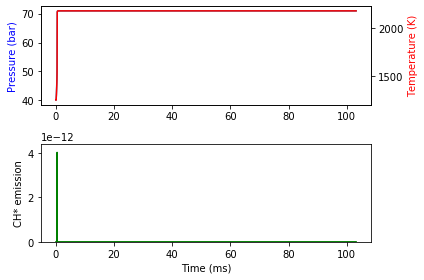

At 1250.0 K 40 bar, ignition delay time is 0.3999881966367712 ms
Performing sensitivity at time 2.2524919754167435e-07 ms at 2176.426642069346 K, 7097522.18646518 Pa

Top 20 sensitivities (of the first 19250 considered)
0 21 IdealGasReactor_2: H2O2(124) (+M) <=> 2 OH(16) (+M) 3.943841160372626e-05
1 62 IdealGasReactor_2: CH2O(9) + OH(16) <=> H2O(8) + HCO(126) -1.3870498558775311e-05
2 7175 IdealGasReactor_2: OH(16) + iC4H8(15) <=> H2O(8) + IC4H7(392) -1.0890476961213547e-05
3 11185 IdealGasReactor_2: C3H6(13) + OH(16) <=> C3H5(208) + H2O(8) -9.537017309029202e-06
4 221 IdealGasReactor_2: C2H6(12) + OH(16) <=> C2H5(140) + H2O(8) -6.319048032498176e-06
5 461 IdealGasReactor_2: CH2CO(131) + OH(16) <=> H2O(8) + HCCO(155) -5.023461580429939e-06
6 98 IdealGasReactor_2: CH3(125) + O2(2) <=> CH2O(9) + OH(16) 4.660911361461562e-06
7 0 IdealGasReactor_2: H(17) + O2(2) <=> O(5) + OH(16) 4.557114417291687e-06
8 78 IdealGasReactor_2: CH4(10) + OH(16) <=> CH3(125) + H2O(8) -3.1194477601031917e-06
9 

In [17]:
initial_idt = get_ignition_delay_air_n2(1000/0.8, 40, 1, plot=True, sensitivity=True)
plt.rcParams['figure.figsize'] = [10, 8]

In [18]:
## Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')

plt.rcParams['figure.autolayout'] = True
import pandas as pd

In [19]:
# Create a dataframe to store sensitivity-analysis data
sensitivities = pd.DataFrame(data=[], index=gas.reaction_equations(ranking[:20]))

In [20]:
# Create an empty column to store the sensitivities data
sensitivities["baseCase"] = ""

In [ ]:
dk = 1e-1 #perturb the oh_sensitivities

for i, j in enumerate(ranking[:20]):
    print(gas.reaction(j))
    gas.set_multiplier(1.0+dk,j)
    print(f"Multiplying reaction {j} rate constant by {dk} in {gas.reaction(j)}")


    new_idt = get_ignition_delay_air_n2(1000/1.2, 40, 1, plot=False, sensitivity=False)
    sensitivities["baseCase"][i] = (new_idt - initial_idt)/(initial_idt*dk)
    
gas.set_multiplier(1.0)

H2O2(124) (+M) <=> 2 OH(16) (+M)
Multiplying reaction 21 rate constant by 0.1 in H2O2(124) (+M) <=> 2 OH(16) (+M)
Reached end time 101.35 ms in 2436 steps
At 833.3333333333334 K 40 bar, ignition delay time is 36.08476740057043 ms
Performing sensitivity at time 5.896927272377963e-07 ms at 1717.6470555149162 K, 8229400.178592439 Pa

Top 20 sensitivities (of the first 19250 considered)
0 21 IdealGasReactor_4: H2O2(124) (+M) <=> 2 OH(16) (+M) 0.0004363886593433975
1 62 IdealGasReactor_4: CH2O(9) + OH(16) <=> H2O(8) + HCO(126) -0.00015757147874449024
2 11185 IdealGasReactor_4: C3H6(13) + OH(16) <=> C3H5(208) + H2O(8) -0.00010527923884273008
3 7175 IdealGasReactor_4: OH(16) + iC4H8(15) <=> H2O(8) + IC4H7(392) -9.72081615605077e-05
4 0 IdealGasReactor_4: H(17) + O2(2) <=> O(5) + OH(16) 9.436014907920887e-05
5 221 IdealGasReactor_4: C2H6(12) + OH(16) <=> C2H5(140) + H2O(8) -8.521407810554962e-05
6 98 IdealGasReactor_4: CH3(125) + O2(2) <=> CH2O(9) + OH(16) 6.656982958370415e-05
7 461 IdealGasR

H(17) + O2(2) <=> O(5) + OH(16)
Multiplying reaction 0 rate constant by 0.1 in H(17) + O2(2) <=> O(5) + OH(16)
Reached end time 100.65 ms in 2398 steps
At 833.3333333333334 K 40 bar, ignition delay time is 36.54953185898248 ms
Performing sensitivity at time 5.896927272377963e-07 ms at 1717.646265218537 K, 8229396.46415521 Pa

Top 20 sensitivities (of the first 19250 considered)
0 21 IdealGasReactor_12: H2O2(124) (+M) <=> 2 OH(16) (+M) 0.0001419419799503904
1 62 IdealGasReactor_12: CH2O(9) + OH(16) <=> H2O(8) + HCO(126) -5.637539683652378e-05
2 11185 IdealGasReactor_12: C3H6(13) + OH(16) <=> C3H5(208) + H2O(8) -3.7666336121605526e-05
3 7175 IdealGasReactor_12: OH(16) + iC4H8(15) <=> H2O(8) + IC4H7(392) -3.4778724209680586e-05
4 0 IdealGasReactor_12: H(17) + O2(2) <=> O(5) + OH(16) 3.3752918678724434e-05
5 221 IdealGasReactor_12: C2H6(12) + OH(16) <=> C2H5(140) + H2O(8) -2.7716031420438493e-05
6 98 IdealGasReactor_12: CH3(125) + O2(2) <=> CH2O(9) + OH(16) 2.165266993375397e-05
7 461 Idea

H2(14) + OH(16) <=> H(17) + H2O(8)
Multiplying reaction 3 rate constant by 0.1 in H2(14) + OH(16) <=> H(17) + H2O(8)
Reached end time 102.51 ms in 2442 steps
At 833.3333333333334 K 40 bar, ignition delay time is 35.955746078280576 ms
Performing sensitivity at time 5.896927272377963e-07 ms at 1717.6462574487332 K, 8229396.455530694 Pa

Top 20 sensitivities (of the first 19250 considered)
0 21 IdealGasReactor_20: H2O2(124) (+M) <=> 2 OH(16) (+M) 0.0001411567570647345
1 62 IdealGasReactor_20: CH2O(9) + OH(16) <=> H2O(8) + HCO(126) -5.6063282660426344e-05
2 11185 IdealGasReactor_20: C3H6(13) + OH(16) <=> C3H5(208) + H2O(8) -3.7457800867321066e-05
3 7175 IdealGasReactor_20: OH(16) + iC4H8(15) <=> H2O(8) + IC4H7(392) -3.458617652998006e-05
4 0 IdealGasReactor_20: H(17) + O2(2) <=> O(5) + OH(16) 3.356623091158268e-05
5 221 IdealGasReactor_20: C2H6(12) + OH(16) <=> C2H5(140) + H2O(8) -3.0318843993798234e-05
6 98 IdealGasReactor_20: CH3(125) + O2(2) <=> CH2O(9) + OH(16) 2.3686173504701647e-05
7

C3H6(13) + O(5) <=> C3H5(208) + OH(16)
Multiplying reaction 11184 rate constant by 0.1 in C3H6(13) + O(5) <=> C3H5(208) + OH(16)
Reached end time 103.86 ms in 2309 steps
At 833.3333333333334 K 40 bar, ignition delay time is 35.411451496604755 ms
Performing sensitivity at time 5.896927272377963e-07 ms at 1717.646167091746 K, 8229396.026344959 Pa

Top 20 sensitivities (of the first 19250 considered)
0 21 IdealGasReactor_28: H2O2(124) (+M) <=> 2 OH(16) (+M) 0.00013749391926593343
1 62 IdealGasReactor_28: CH2O(9) + OH(16) <=> H2O(8) + HCO(126) -5.460846950036814e-05
2 11185 IdealGasReactor_28: C3H6(13) + OH(16) <=> C3H5(208) + H2O(8) -3.6485789026042095e-05
3 7175 IdealGasReactor_28: OH(16) + iC4H8(15) <=> H2O(8) + IC4H7(392) -3.368868226109684e-05
4 0 IdealGasReactor_28: H(17) + O2(2) <=> O(5) + OH(16) 3.269524359220321e-05
5 221 IdealGasReactor_28: C2H6(12) + OH(16) <=> C2H5(140) + H2O(8) -2.953208609733979e-05
6 98 IdealGasReactor_28: CH3(125) + O2(2) <=> CH2O(9) + OH(16) 2.307154492019

C3H4(279) + OH(16) <=> C3H3(182) + H2O(8)
Multiplying reaction 4949 rate constant by 0.1 in C3H4(279) + OH(16) <=> C3H3(182) + H2O(8)
Reached end time 103.05 ms in 2528 steps
At 833.3333333333334 K 40 bar, ignition delay time is 35.308159483821285 ms
Performing sensitivity at time 5.896927272377963e-07 ms at 1717.6465254230136 K, 8229397.751459804 Pa

Top 20 sensitivities (of the first 19250 considered)
0 21 IdealGasReactor_36: H2O2(124) (+M) <=> 2 OH(16) (+M) 0.0001373244049799893
1 62 IdealGasReactor_36: CH2O(9) + OH(16) <=> H2O(8) + HCO(126) -5.454114519981151e-05
2 11185 IdealGasReactor_36: C3H6(13) + OH(16) <=> C3H5(208) + H2O(8) -3.6440807292533505e-05
3 7175 IdealGasReactor_36: OH(16) + iC4H8(15) <=> H2O(8) + IC4H7(392) -3.3647148987511935e-05
4 0 IdealGasReactor_36: H(17) + O2(2) <=> O(5) + OH(16) 3.265511353284672e-05
5 221 IdealGasReactor_36: C2H6(12) + OH(16) <=> C2H5(140) + H2O(8) -2.9495677339575143e-05
6 98 IdealGasReactor_36: CH3(125) + O2(2) <=> CH2O(9) + OH(16) 2.30431

In [25]:
sensitivities.head()

,baseCase
H2O2(124) (+M) <=> 2 OH(16) (+M),-1.05041
OH(16) + iC8H18(1) <=> H2O(8) + R_1(18),-1.21875
CH2O(9) + OH(16) <=> H2O(8) + HCO(126),-1.04383
OH(16) + iC4H8(15) <=> H2O(8) + IC4H7(392),-1.18539
OH(16) + iC8H18(1) <=> H2O(8) + R_4(21),-1.28885


Text(0.5, 0, 'Sensitivity: $\\frac{\\partial\\:\\ln{(\\tau_{ign}=t([CH^*]_{max}))}}{\\partial\\:\\ln{k}}$')

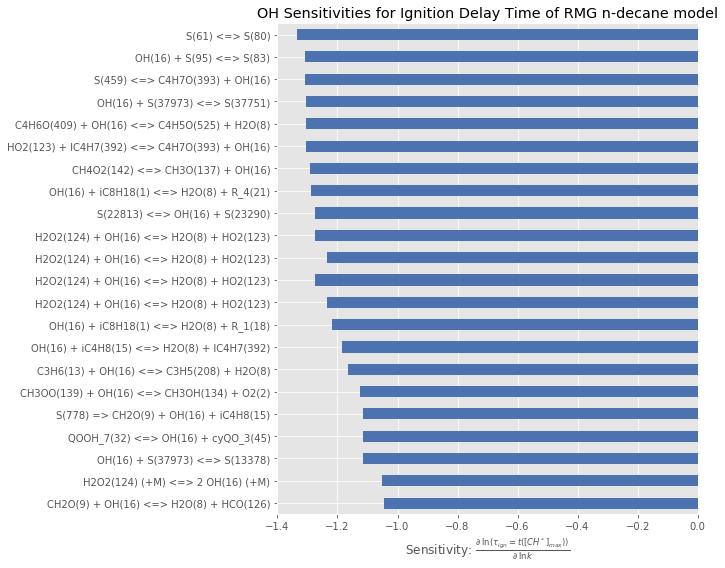

In [26]:
# Reaction mechanisms can contains thousands of elementary steps. Choose a threshold
# to see only the top few
threshold = 0.03

firstColumn = sensitivities.columns[0]

# For plotting, collect only those steps that are above the threshold
# Otherwise, the y-axis gets crowded and illegible
sensitivitiesSubset = sensitivities[sensitivities[firstColumn].abs() > threshold]
indicesMeetingThreshold = sensitivitiesSubset[firstColumn].abs().sort_values(ascending=False).index
sensitivitiesSubset.loc[indicesMeetingThreshold].plot.barh(title="OH Sensitivities for Ignition Delay Time of RMG n-decane model",
                                                          legend=None)
plt.gca().invert_yaxis()

plt.rcParams.update({'axes.labelsize': 20})
plt.xlabel(r'Sensitivity: $\frac{\partial\:\ln{(\tau_{ign}=t([CH^*]_{max}))}}{\partial\:\ln{k}}$')


# Uncomment the following to save the plot. A higher than usual resolution (dpi) helps
# plt.savefig('sensitivityPlot', dpi=300)

In [21]:
RMG_temperatures = 1000/np.linspace(0.70,1.6,15)
pressures_bar = 16
phi = 1

RMG_results = dict()
times = []
for T in RMG_temperatures:
    t = get_ignition_delay_air_n2(T,pressures_bar, phi, plot=False, sensitivity=False)
    times.append(t)
    RMG_results[pressures_bar]=times

Reached end time 103.45 ms in 1707 steps
At 1428.5714285714287 K 16 bar, ignition delay time is 0.17076542572370645 ms
Performing sensitivity at time 2.2524919754167435e-07 ms at 2239.5320950663645 K, 2511597.173087365 Pa

Top 20 sensitivities (of the first 19250 considered)
0 21 IdealGasReactor_4: H2O2(124) (+M) <=> 2 OH(16) (+M) 3.943841160372626e-05
1 62 IdealGasReactor_4: CH2O(9) + OH(16) <=> H2O(8) + HCO(126) -1.3870498558775311e-05
2 7175 IdealGasReactor_4: OH(16) + iC4H8(15) <=> H2O(8) + IC4H7(392) -1.0890476961213547e-05
3 11185 IdealGasReactor_4: C3H6(13) + OH(16) <=> C3H5(208) + H2O(8) -9.537017309029202e-06
4 221 IdealGasReactor_4: C2H6(12) + OH(16) <=> C2H5(140) + H2O(8) -6.319048032498176e-06
5 461 IdealGasReactor_4: CH2CO(131) + OH(16) <=> H2O(8) + HCCO(155) -5.023461580429939e-06
6 98 IdealGasReactor_4: CH3(125) + O2(2) <=> CH2O(9) + OH(16) 4.660911361461562e-06
7 0 IdealGasReactor_4: H(17) + O2(2) <=> O(5) + OH(16) 4.557114417291687e-06
8 78 IdealGasReactor_4: CH4(10) +

Reached end time 101.93 ms in 2128 steps
At 1044.7761194029852 K 16 bar, ignition delay time is 7.638889159083949 ms
Performing sensitivity at time 2.2524919754167435e-07 ms at 1900.060338495046 K, 2910417.8408872997 Pa

Top 20 sensitivities (of the first 19250 considered)
0 21 IdealGasReactor_12: H2O2(124) (+M) <=> 2 OH(16) (+M) 3.943841160372626e-05
1 62 IdealGasReactor_12: CH2O(9) + OH(16) <=> H2O(8) + HCO(126) -1.3870498558775311e-05
2 7175 IdealGasReactor_12: OH(16) + iC4H8(15) <=> H2O(8) + IC4H7(392) -1.0890476961213547e-05
3 11185 IdealGasReactor_12: C3H6(13) + OH(16) <=> C3H5(208) + H2O(8) -9.537017309029202e-06
4 221 IdealGasReactor_12: C2H6(12) + OH(16) <=> C2H5(140) + H2O(8) -6.319048032498176e-06
5 461 IdealGasReactor_12: CH2CO(131) + OH(16) <=> H2O(8) + HCCO(155) -5.023461580429939e-06
6 98 IdealGasReactor_12: CH3(125) + O2(2) <=> CH2O(9) + OH(16) 4.660911361461562e-06
7 0 IdealGasReactor_12: H(17) + O2(2) <=> O(5) + OH(16) 4.557114417291687e-06
8 78 IdealGasReactor_12: CH

Reached end time 100.04 ms in 1438 steps
At 823.5294117647057 K 16 bar, no ignition detected
Performing sensitivity at time 2.2524919754167435e-07 ms at 1217.7490753613229 K, 2392396.315271498 Pa

Top 20 sensitivities (of the first 19250 considered)
0 21 IdealGasReactor_20: H2O2(124) (+M) <=> 2 OH(16) (+M) 3.943841160372626e-05
1 62 IdealGasReactor_20: CH2O(9) + OH(16) <=> H2O(8) + HCO(126) -1.3870498558775311e-05
2 7175 IdealGasReactor_20: OH(16) + iC4H8(15) <=> H2O(8) + IC4H7(392) -1.0890476961213547e-05
3 11185 IdealGasReactor_20: C3H6(13) + OH(16) <=> C3H5(208) + H2O(8) -9.537017309029202e-06
4 221 IdealGasReactor_20: C2H6(12) + OH(16) <=> C2H5(140) + H2O(8) -6.319048032498176e-06
5 461 IdealGasReactor_20: CH2CO(131) + OH(16) <=> H2O(8) + HCCO(155) -5.023461580429939e-06
6 98 IdealGasReactor_20: CH3(125) + O2(2) <=> CH2O(9) + OH(16) 4.660911361461562e-06
7 0 IdealGasReactor_20: H(17) + O2(2) <=> O(5) + OH(16) 4.557114417291687e-06
8 78 IdealGasReactor_20: CH4(10) + OH(16) <=> CH3(1

Reached end time 100.53 ms in 1003 steps
At 679.6116504854368 K 16 bar, no ignition detected
Performing sensitivity at time 2.2524919754167435e-07 ms at 707.1954266899028 K, 1665165.2156836109 Pa

Top 20 sensitivities (of the first 19250 considered)
0 21 IdealGasReactor_28: H2O2(124) (+M) <=> 2 OH(16) (+M) 3.943841160372626e-05
1 62 IdealGasReactor_28: CH2O(9) + OH(16) <=> H2O(8) + HCO(126) -1.3870498558775311e-05
2 7175 IdealGasReactor_28: OH(16) + iC4H8(15) <=> H2O(8) + IC4H7(392) -1.0890476961213547e-05
3 11185 IdealGasReactor_28: C3H6(13) + OH(16) <=> C3H5(208) + H2O(8) -9.537017309029202e-06
4 221 IdealGasReactor_28: C2H6(12) + OH(16) <=> C2H5(140) + H2O(8) -6.319048032498176e-06
5 461 IdealGasReactor_28: CH2CO(131) + OH(16) <=> H2O(8) + HCCO(155) -5.023461580429939e-06
6 98 IdealGasReactor_28: CH3(125) + O2(2) <=> CH2O(9) + OH(16) 4.660911361461562e-06
7 0 IdealGasReactor_28: H(17) + O2(2) <=> O(5) + OH(16) 4.557114417291687e-06
8 78 IdealGasReactor_28: CH4(10) + OH(16) <=> CH3(1

In [18]:
RMG_temperatures = 1000/np.linspace(0.70,1.6,15)
pressures_bar = 40
phi = 1

RMG_results = dict()
times = []
for T in RMG_temperatures:
    t = get_ignition_delay_air_n2(T,pressures_bar, phi, plot=False, sensitivity=False)
    times.append(t)
    RMG_results[pressures_bar]=times

Reached end time 101.04 ms in 374 steps
At 1428.5714285714287 K 40 bar, no ignition detected
Reached end time 101.34 ms in 318 steps
At 1308.4112149532712 K 40 bar, no ignition detected
Reached end time 100.46 ms in 280 steps
At 1206.896551724138 K 40 bar, no ignition detected
Reached end time 101.96 ms in 221 steps
At 1120.0 K 40 bar, no ignition detected
Reached end time 100.49 ms in 171 steps
At 1044.7761194029852 K 40 bar, no ignition detected
Reached end time 101.42 ms in 130 steps
At 979.0209790209791 K 40 bar, no ignition detected
Reached end time 104.96 ms in 105 steps
At 921.0526315789473 K 40 bar, no ignition detected
Reached end time 100.92 ms in 85 steps
At 869.5652173913044 K 40 bar, no ignition detected
Reached end time 106.89 ms in 77 steps
At 823.5294117647057 K 40 bar, no ignition detected
Reached end time 102.79 ms in 64 steps
At 782.122905027933 K 40 bar, no ignition detected
Reached end time 107.67 ms in 53 steps
At 744.6808510638298 K 40 bar, no ignition detected
R

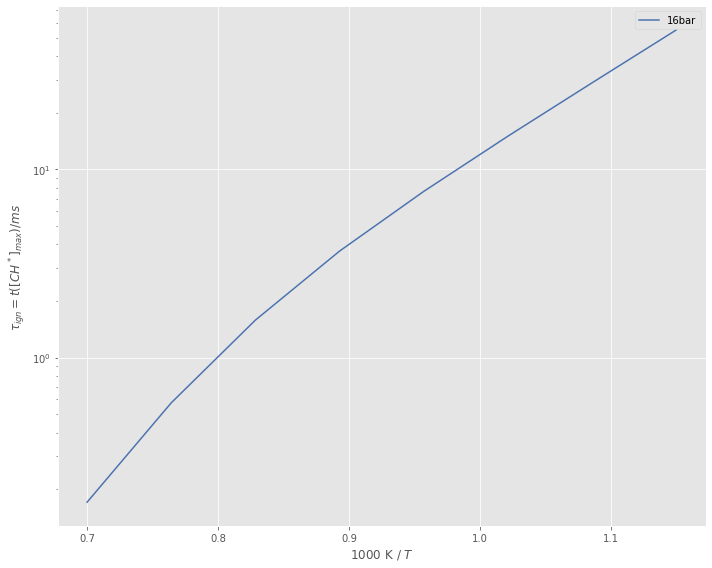

In [22]:
plt.semilogy(1000/RMG_temperatures,RMG_results[pressures_bar],label='{}bar'.format(pressures_bar))
plt.legend(loc='best')
plt.xlabel('1000 K / $T$')
plt.ylabel('$\\tau_{ign} = t([CH^*]_{max})/ms$')
plt.rcParams['figure.figsize'] = [10, 8]

In [ ]:
import pickle
with open('ic8-RMG_no_moving_wall.pkl','wb') as fp:
    pickle.dump((RMG_temperatures, RMG_results[pressures_bar]), fp)

In [24]:
# extracted values of predicted ignition delay for iso-octane in Fig.14 
# using the docstrings
predict_ic8 = """0.657614                 0.0438935
0.660053                 0.0508193
0.668666                 0.0605986
0.674810                 0.0712038
0.682193                 0.0824521
0.690803                 0.0997690
0.695710                 0.117224
0.705556                 0.141850
0.712933                 0.169140
0.722793                 0.193028
0.730166                 0.233559
0.740019                 0.274467
0.748628                 0.332111
0.759721                 0.384622
0.765868                 0.445364
0.775710                 0.546873
0.786810                 0.615061
0.799138                 0.712339
0.806515                 0.849383
0.818843                 0.983721
0.829936                 1.13926
0.843501                 1.31950
0.852120                 1.52800
0.864449                 1.76967
0.878014                 2.04964
0.889110                 2.33921
0.900212                 2.59264
0.910061                 3.09168
0.927338                 3.52918
0.935965                 3.96890
0.942116                 4.52889
0.958153                 5.24581
0.969245                 6.07524
0.985293                 6.73451
0.993909                 7.91373
1.00872                  8.90155
1.02476                  9.86753
1.03338                  11.4268
1.04572                  12.8521
1.06423                  14.6714
1.07409                  16.9904
1.08520                  18.5574
1.10124                  21.1825
1.11357                  23.4784
1.12466                  27.5917
1.13824                  30.1389
1.14933                  35.4191
1.16290                  39.8386
1.17523                  46.1394
1.18633                  51.8925
1.19865                  61.8858
1.20728                  68.5850
1.21961                  80.6040
1.23070                  94.7255
"""

ign_times = []
temps = []

for k in predict_ic8.splitlines():
    temp, ign_time = k.split()
    temps.append(float(temp))
    ign_times.append(float(ign_time))
    
ign_times = np.array(ign_times)
temps = np.array(temps)
#print(temps, ign_times)

{16: [0.19400338315591503, 0.6095751364559909, 1.3769798954699703, 3.0837628385410545, 7.476224832830604, 14.757501739086182, 29.370524748284016, 75.96537230375985, inf, inf, inf, inf, inf, inf, inf]}
<class 'dict'>


<function matplotlib.pyplot.show(*args, **kw)>

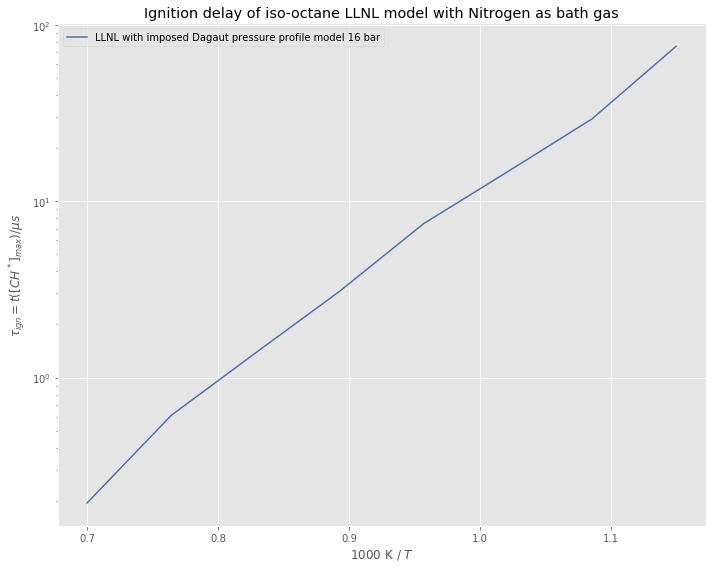

In [31]:
import pickle 


pickle_in = open('ic8-LLNL', 'rb')       
new_dict = pickle.load(pickle_in)
pickle_in.close()

print(new_dict)
# print(new_dict==LLNL_results)
# print(LLNL_results)
print(type(new_dict))
# type(LLNL_results)

# LLNL_results[1]
for key, val in new_dict.items():
    plt.semilogy(1000/RMG_temperatures, val, '-', label= 'LLNL with imposed Dagaut pressure profile model {} bar'.format(key))
    
plt.legend(loc='best')
plt.xlabel('1000 K / $T$')
plt.ylabel('$\\tau_{ign} = t([CH^*]_{max})/\mu s$')
plt.rcParams['figure.figsize'] = [10, 8]
plt.title('Ignition delay of iso-octane LLNL model with Nitrogen as bath gas')
plt.show

Text(0.5, 1.0, "Dagaut's Figure 14, iso-octane")

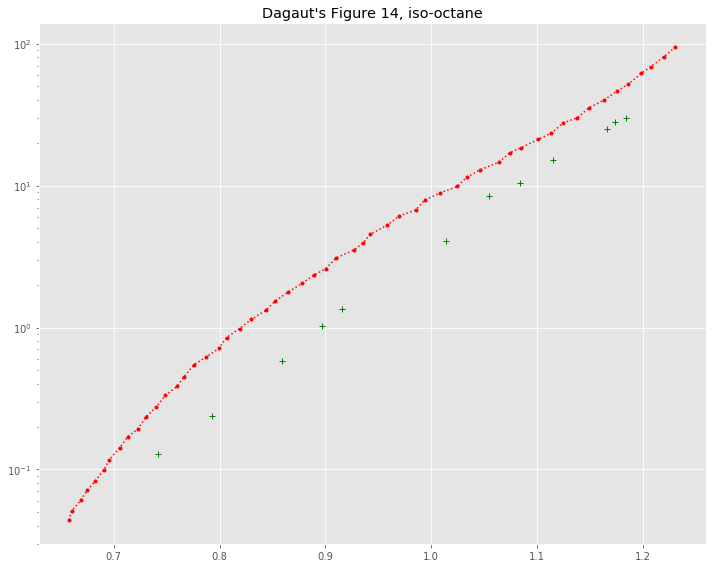

In [32]:
experiment_ic8 = """ 0.742197            0.129438
0.792731            0.238540
0.858775            0.582623
0.897119            1.02386
0.916046            1.35725
1.01424             4.07608
1.05446             8.48794
1.08368             10.3738
1.11478             15.2007
1.16585             24.9217
1.17410             28.0282
1.18433             30.0848
"""

exp_ign_times = []
exp_temps = []



for z in experiment_ic8.splitlines():
    exp_temp, exp_ign_time = z.split()
    exp_temps.append(float(exp_temp))
    exp_ign_times.append(float(exp_ign_time))
    
exp_ign_times = np.array(exp_ign_times)
exp_temps = np.array(exp_temps)

plt.semilogy(temps,ign_times, 'r.:')
plt.semilogy(exp_temps,exp_ign_times, 'g+')
plt.title("Dagaut's Figure 14, iso-octane")

<function matplotlib.pyplot.show(*args, **kw)>

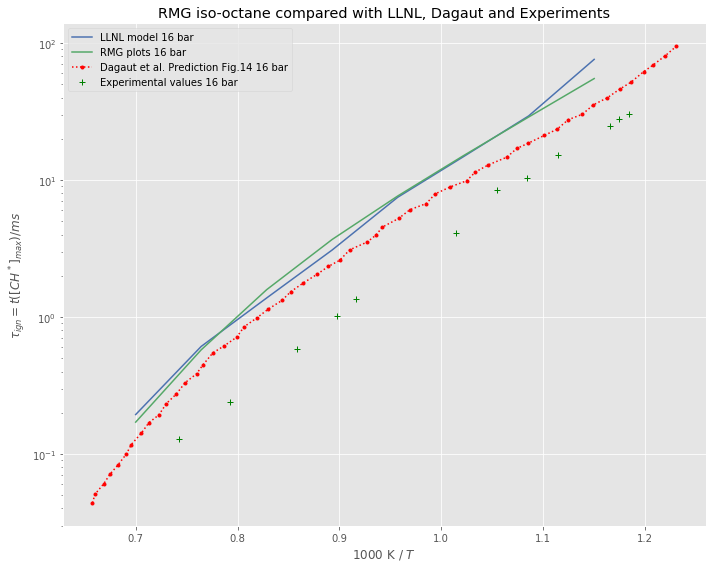

In [33]:
for key, val in new_dict.items():
    plt.semilogy(1000/RMG_temperatures, val, '-', label= 'LLNL model {} bar'.format(key))

plt.semilogy(1000/RMG_temperatures,RMG_results[pressures_bar],label='RMG plots {} bar'.format(pressures_bar))
plt.semilogy(temps,ign_times, 'r.:', label='Dagaut et al. Prediction Fig.14 {} bar'.format(pressures_bar))
plt.semilogy(exp_temps,exp_ign_times, 'g+',label='Experimental values {} bar'.format(pressures_bar))
plt.legend(loc='best')
plt.xlabel('1000 K / $T$')
plt.ylabel('$\\tau_{ign} = t([CH^*]_{max})/ms$')
plt.title("RMG iso-octane compared with LLNL, Dagaut and Experiments")
plt.rcParams['figure.figsize'] = [10, 8]
plt.show